# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Необходимо проверить как минимум LightGBM и одну модель не бустинг. Параметр качества- RSME, должен быть не выше 2500.

## Подготовка данных

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install scikit-learn==1.1.3


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip3 install catboost


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder,StandardScaler,OrdinalEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import make_scorer
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
import time

In [5]:
data = pd.read_csv('autos.csv.crdownload')

In [6]:
data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480.0,NaN,1993.0,manual,0.0,golf,150000.0,0.0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0.0,70435.0,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300.0,coupe,2011.0,manual,190.0,NaN,125000.0,5.0,gasoline,audi,yes,2016-03-24 00:00:00,0.0,66954.0,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800.0,suv,2004.0,auto,163.0,grand,125000.0,8.0,gasoline,jeep,NaN,2016-03-14 00:00:00,0.0,90480.0,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500.0,small,2001.0,manual,75.0,golf,150000.0,6.0,petrol,volkswagen,no,2016-03-17 00:00:00,0.0,91074.0,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600.0,small,2008.0,manual,69.0,fabia,90000.0,7.0,gasoline,skoda,no,2016-03-31 00:00:00,0.0,60437.0,2016-04-06 10:17:21


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154256 entries, 0 to 154255
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DateCrawled        154256 non-null  object 
 1   Price              154255 non-null  float64
 2   VehicleType        138045 non-null  object 
 3   RegistrationYear   154255 non-null  float64
 4   Gearbox            145645 non-null  object 
 5   Power              154255 non-null  float64
 6   Model              145674 non-null  object 
 7   Kilometer          154255 non-null  float64
 8   RegistrationMonth  154255 non-null  float64
 9   FuelType           139888 non-null  object 
 10  Brand              154255 non-null  object 
 11  Repaired           123198 non-null  object 
 12  DateCreated        154255 non-null  object 
 13  NumberOfPictures   154255 non-null  float64
 14  PostalCode         154255 non-null  float64
 15  LastSeen           154255 non-null  object 
dtypes:

для предсказания цены автомобиля не играют роли такие признаки как: DateCrawled,PostalCode,LastSeen,RegistrationMonth,RegistrationMonth

In [8]:
data.drop(['DateCrawled', 'PostalCode', 'LastSeen','RegistrationMonth','DateCreated'], axis = 1, inplace= True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154256 entries, 0 to 154255
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             154255 non-null  float64
 1   VehicleType       138045 non-null  object 
 2   RegistrationYear  154255 non-null  float64
 3   Gearbox           145645 non-null  object 
 4   Power             154255 non-null  float64
 5   Model             145674 non-null  object 
 6   Kilometer         154255 non-null  float64
 7   FuelType          139888 non-null  object 
 8   Brand             154255 non-null  object 
 9   Repaired          123198 non-null  object 
 10  NumberOfPictures  154255 non-null  float64
dtypes: float64(5), object(6)
memory usage: 12.9+ MB


In [10]:
data.columns = data.columns.str.lower()

In [11]:
data

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired,numberofpictures
0,480.0,NaN,1993.0,manual,0.0,golf,150000.0,petrol,volkswagen,NaN,0.0
1,18300.0,coupe,2011.0,manual,190.0,NaN,125000.0,gasoline,audi,yes,0.0
2,9800.0,suv,2004.0,auto,163.0,grand,125000.0,gasoline,jeep,NaN,0.0
3,1500.0,small,2001.0,manual,75.0,golf,150000.0,petrol,volkswagen,no,0.0
4,3600.0,small,2008.0,manual,69.0,fabia,90000.0,gasoline,skoda,no,0.0
...,...,...,...,...,...,...,...,...,...,...,...
154251,5000.0,NaN,2007.0,NaN,0.0,touran,5000.0,gasoline,volkswagen,no,0.0
154252,900.0,small,1996.0,manual,0.0,polo,150000.0,petrol,volkswagen,no,0.0
154253,5200.0,sedan,2006.0,auto,105.0,astra,125000.0,petrol,opel,no,0.0
154254,2800.0,wagon,2006.0,manual,125.0,astra,150000.0,petrol,opel,yes,0.0


In [12]:
data.rename(columns= {'vehicletype':'vehicle_type', 'registrationyear':'registration_year','fueltype':'fuel_type', 'numberofpictures':'number_of_pictures'}, inplace=True)

<function matplotlib.pyplot.show(close=None, block=None)>

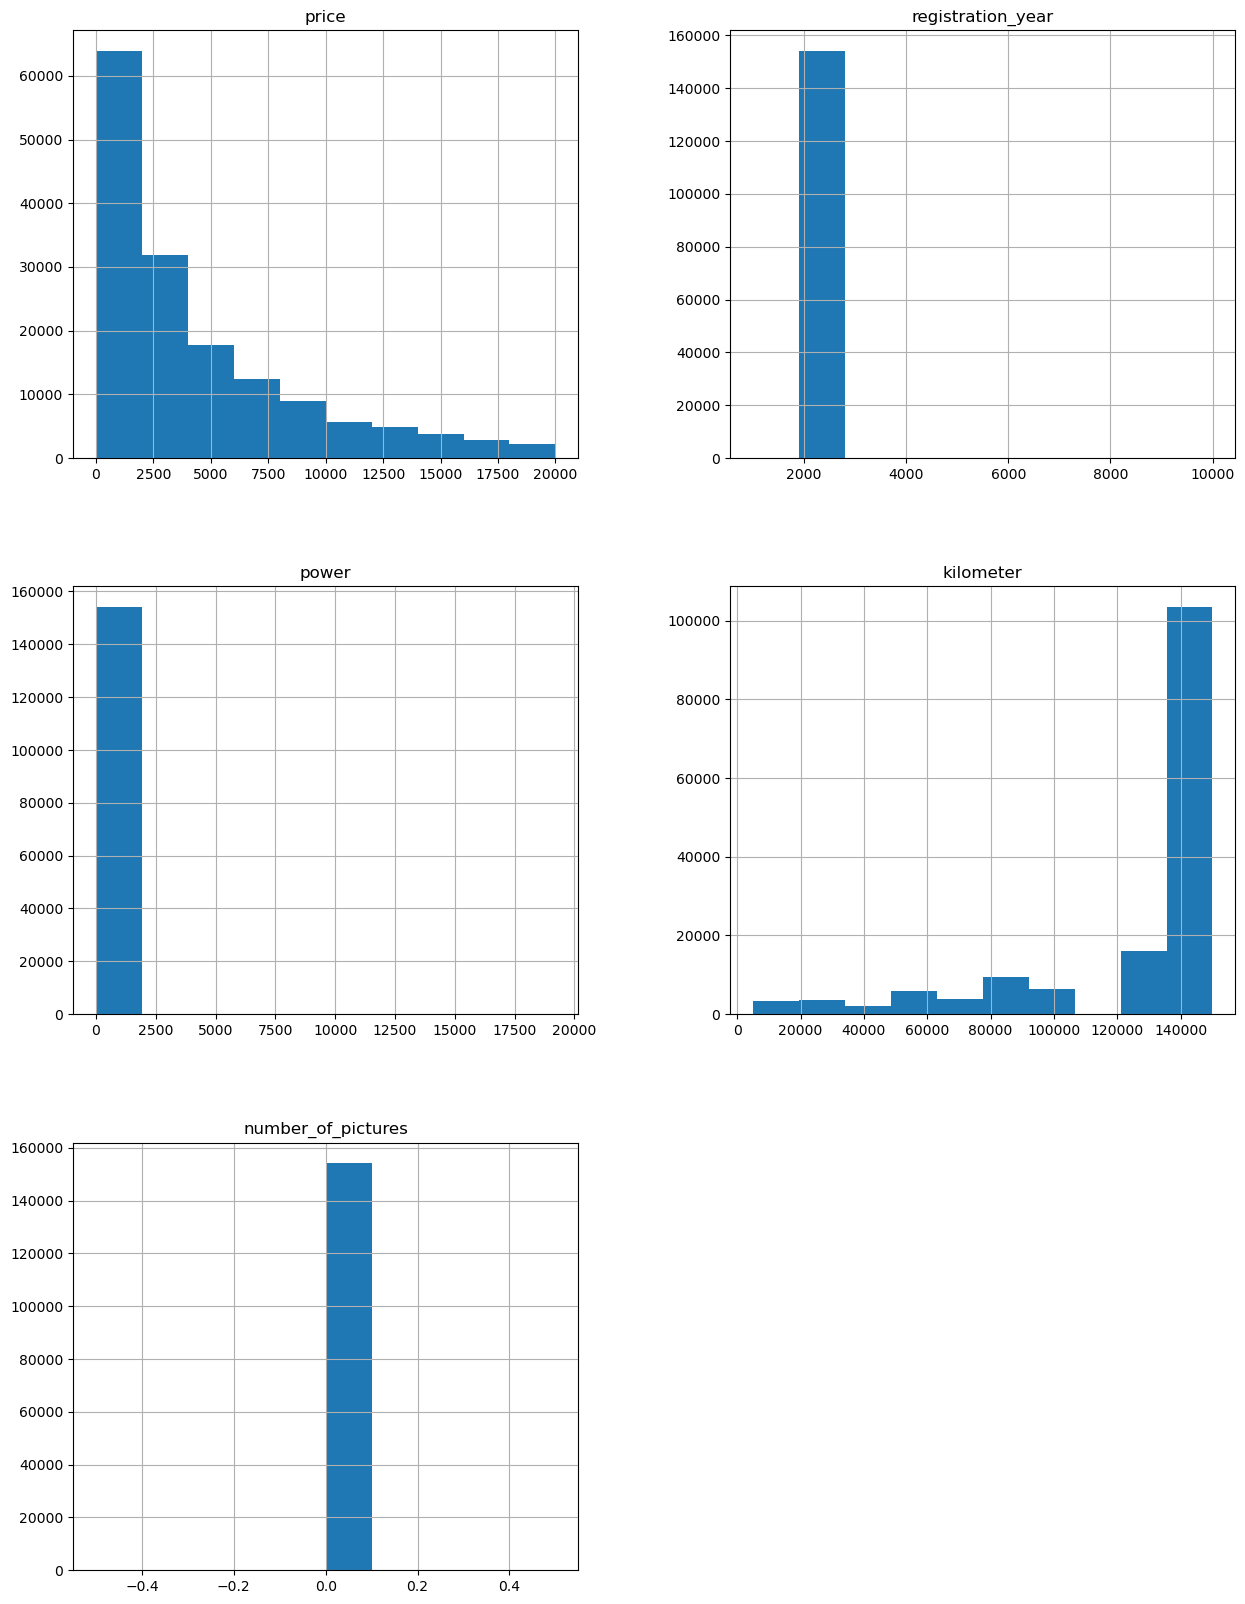

In [13]:
data.hist(figsize=(15,20))
plt.show

По первому взгляду на графики можно сразу отметить, что точно есть какая-то ошибка или выброс в признаках RegistrationYear и Power, а еще огромное количество автомобилей с нулевой ценой. Еще вызывает подозрение признак NumberOfPictures(там что, одни нули?). ПОсмотрим колонку number_of_pictures, чтобы сразу удалить ее сразу, если там действительно нули

In [14]:
data.number_of_pictures.describe()

count    154255.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: number_of_pictures, dtype: float64

Действительно, одни нуди.удаляем этот признак

In [15]:
data.drop('number_of_pictures', axis=1,inplace=True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154256 entries, 0 to 154255
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              154255 non-null  float64
 1   vehicle_type       138045 non-null  object 
 2   registration_year  154255 non-null  float64
 3   gearbox            145645 non-null  object 
 4   power              154255 non-null  float64
 5   model              145674 non-null  object 
 6   kilometer          154255 non-null  float64
 7   fuel_type          139888 non-null  object 
 8   brand              154255 non-null  object 
 9   repaired           123198 non-null  object 
dtypes: float64(4), object(6)
memory usage: 11.8+ MB


In [17]:
data.duplicated().sum()

10543

In [18]:
data = data.drop_duplicates()

In [19]:
data.reset_index(drop=True, inplace=True)

## Подготовка выборок

разобьем выборку на обучающу, тестовую и валидационную.

In [20]:
all_train, test = train_test_split(data, test_size=0.2, random_state=2023)

In [21]:
train, valid = train_test_split(all_train, test_size=0.2, random_state=2023)

In [22]:
valid_features = valid.drop('price', axis=1)
test_features = test.drop('price', axis=1)

In [23]:
valid_target = valid['price']
test_target = test['price']

Обработаем порпуски и выбросы в обучающей выборке. посмотрим внимательнее на данные, где год регистрации выше текущего (2023)

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91976 entries, 1184 to 31226
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              91975 non-null  float64
 1   vehicle_type       82022 non-null  object 
 2   registration_year  91975 non-null  float64
 3   gearbox            86918 non-null  object 
 4   power              91975 non-null  float64
 5   model              86729 non-null  object 
 6   kilometer          91975 non-null  float64
 7   fuel_type          83043 non-null  object 
 8   brand              91975 non-null  object 
 9   repaired           73087 non-null  object 
dtypes: float64(4), object(6)
memory usage: 7.7+ MB


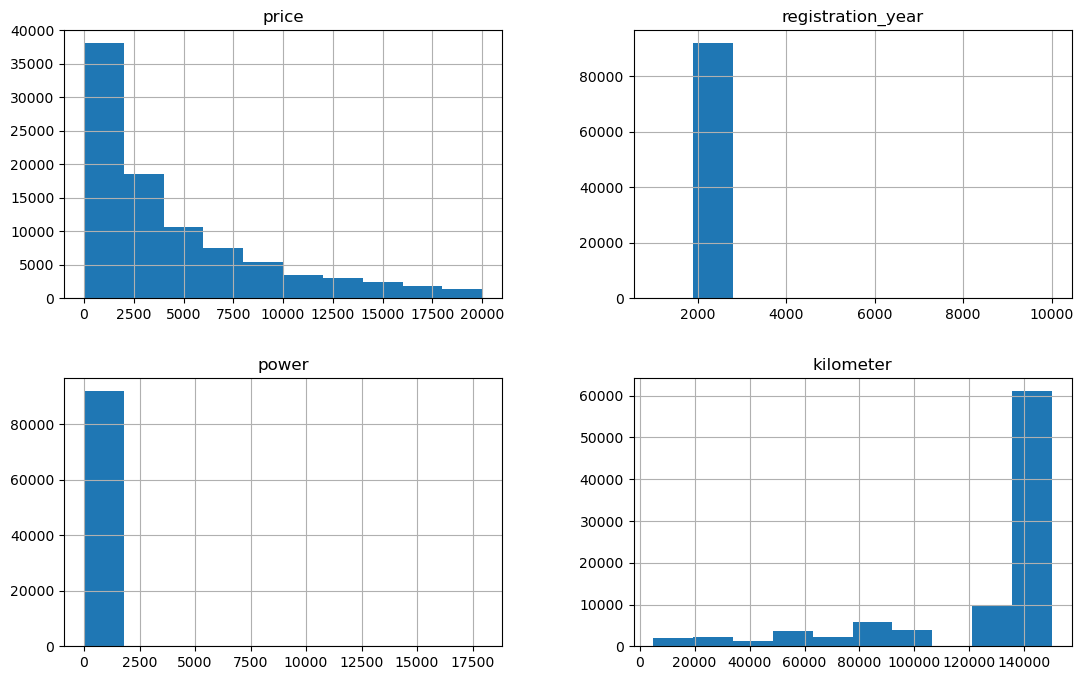

In [25]:
train.hist(figsize=(13,8))
plt.show()

In [26]:
train.loc[train['registration_year']>2023]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
101221,0.0,NaN,5000.0,NaN,0.0,3er,5000.0,NaN,bmw,NaN
139188,400.0,NaN,9999.0,NaN,0.0,NaN,10000.0,NaN,sonstige_autos,NaN
130868,3500.0,NaN,2500.0,NaN,0.0,NaN,5000.0,gasoline,volkswagen,NaN
17070,700.0,NaN,9999.0,NaN,0.0,other,10000.0,NaN,opel,NaN
76153,1500.0,NaN,3700.0,manual,0.0,zafira,5000.0,cng,opel,NaN
26103,800.0,NaN,2066.0,NaN,0.0,zafira,5000.0,gasoline,opel,NaN
15000,0.0,NaN,9999.0,NaN,0.0,NaN,10000.0,NaN,sonstige_autos,NaN
103515,1.0,NaN,6500.0,manual,120.0,other,10000.0,gasoline,peugeot,no
64100,1.0,NaN,8000.0,NaN,55.0,golf,10000.0,petrol,volkswagen,NaN
44464,999.0,NaN,9000.0,NaN,0.0,fiesta,10000.0,NaN,ford,yes


Видим, что эти данные неинформативны. Логичнее всего будет их удалить. Подозреваю, что была какая-то ошибка в выгрузке данных или ранее. Теперь посмотрим данные с очень ранними годами регистрации. Первый автомобиль был изобретен в 1886 году. Автомобили старше 30 лет уже считаются раритетными. Т.о. делаем вывод, что со 100% вероятностью все года регистрации ранее 1886 года - ошибки, а все, что между 1886 и 1989 это либо ошибка либо старые машины и раритет (разница в цене может быть колоссальная). Предполагаю, что данные за 2019 год.

Также данные выглядят скорее результатом ошибки. Подлежат удалению. Теперь посмотрим что там в промежутке 1886 - 1993

In [27]:
train.loc[train['registration_year']<1886]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
33585,450.0,NaN,1800.0,NaN,1800.0,NaN,5000.0,NaN,mitsubishi,no
64256,0.0,NaN,1200.0,auto,1200.0,punto,150000.0,petrol,fiat,NaN
122131,1000.0,NaN,1000.0,NaN,0.0,NaN,5000.0,NaN,sonstige_autos,NaN
138671,0.0,NaN,1688.0,NaN,0.0,NaN,5000.0,NaN,rover,NaN
64770,0.0,NaN,1500.0,NaN,0.0,kuga,5000.0,gasoline,ford,NaN
63858,1300.0,NaN,1000.0,auto,0.0,NaN,5000.0,petrol,sonstige_autos,NaN
68765,500.0,NaN,1000.0,NaN,0.0,golf,5000.0,NaN,volkswagen,NaN
106625,2500.0,NaN,1000.0,NaN,0.0,NaN,5000.0,NaN,trabant,no
104259,400.0,NaN,1000.0,NaN,0.0,NaN,5000.0,NaN,mercedes_benz,no
99384,100.0,NaN,1234.0,NaN,0.0,156,5000.0,petrol,alfa_romeo,NaN


In [28]:
short_data = train.query('registration_year>1886 & registration_year<1989')

In [29]:
short_data

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
83136,6000.0,sedan,1982.0,manual,60.0,other,150000.0,gasoline,mercedes_benz,no
1837,1500.0,other,1985.0,auto,0.0,other,50000.0,petrol,chevrolet,NaN
98048,4500.0,convertible,1986.0,manual,90.0,NaN,100000.0,petrol,bmw,NaN
22716,5900.0,sedan,1983.0,manual,0.0,golf,150000.0,petrol,volkswagen,NaN
78075,3250.0,sedan,1988.0,manual,0.0,3er,150000.0,petrol,bmw,NaN
...,...,...,...,...,...,...,...,...,...,...
37188,10.0,NaN,1980.0,NaN,0.0,601,100000.0,NaN,trabant,NaN
126302,8950.0,coupe,1984.0,manual,101.0,other,60000.0,petrol,ford,no
78767,4000.0,sedan,1982.0,manual,60.0,other,150000.0,gasoline,mercedes_benz,no
26419,14500.0,sedan,1971.0,manual,98.0,other,80000.0,petrol,citroen,no


<function matplotlib.pyplot.show(close=None, block=None)>

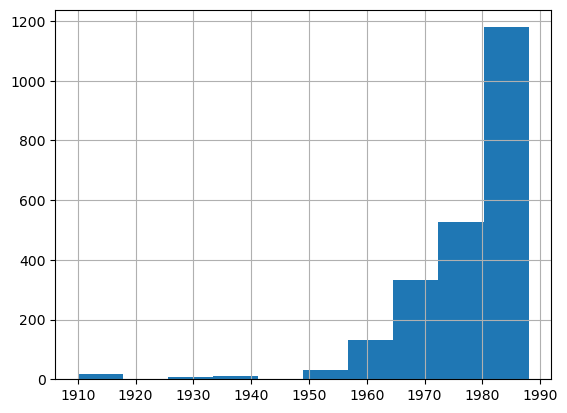

In [30]:
short_data['registration_year'].hist()
plt.show

In [31]:
short_data.sort_values(by='registration_year', ascending =False)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
43292,8000.0,sedan,1988.0,manual,72.0,e_klasse,70000.0,gasoline,mercedes_benz,no
25042,1400.0,small,1988.0,manual,0.0,other,60000.0,petrol,citroen,no
138606,2300.0,wagon,1988.0,auto,0.0,3er,90000.0,petrol,bmw,NaN
18329,1600.0,coupe,1988.0,manual,113.0,3er,150000.0,petrol,bmw,no
74974,850.0,sedan,1988.0,auto,132.0,e_klasse,150000.0,petrol,mercedes_benz,NaN
...,...,...,...,...,...,...,...,...,...,...
129450,0.0,NaN,1910.0,NaN,0.0,combo,150000.0,NaN,opel,NaN
89861,0.0,wagon,1910.0,NaN,0.0,NaN,150000.0,petrol,sonstige_autos,NaN
93303,1.0,sedan,1910.0,manual,10.0,other,5000.0,gasoline,mercedes_benz,no
24062,50.0,small,1910.0,manual,0.0,NaN,5000.0,NaN,volkswagen,yes


Выглядит так, что все, что меньше 1950 года- что-то ошибочное. По крайней мере 1910 год. Оставим срез с 1910 по 1950 год. 

In [32]:
train = train.query('registration_year>1910 & registration_year<=2016')

Теперь расмотрим все данные, у которых слишком низкая цена. Поставим границу 50 евро. 

In [33]:
train.query('price<50')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
522,0.0,NaN,2000.0,NaN,0.0,NaN,150000.0,NaN,volvo,NaN
15764,1.0,small,2007.0,manual,0.0,other,125000.0,petrol,peugeot,no
90041,0.0,convertible,1997.0,manual,90.0,golf,150000.0,petrol,volkswagen,NaN
24148,0.0,wagon,1996.0,manual,0.0,5er,150000.0,gasoline,bmw,NaN
26538,0.0,NaN,1995.0,NaN,0.0,golf,5000.0,NaN,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...
42071,0.0,small,1992.0,manual,60.0,NaN,150000.0,gasoline,volkswagen,no
13521,0.0,sedan,2006.0,manual,177.0,5er,150000.0,petrol,bmw,NaN
32233,0.0,wagon,1991.0,manual,115.0,passat,150000.0,petrol,volkswagen,NaN
103192,0.0,small,2001.0,manual,58.0,twingo,150000.0,petrol,renault,no


Видим около 6,6 тысяч записей с ценой меньше 100. Много цен 0 и 1 евро. Откуда эти значения- узнать бы у коллег, но т.к. такой возможности нет, то считаю, что эти данные нужно удалить. Вряд ли хоть кому-то из пользвоателей захочется увидеть предсказание от модели "ваш автомобиль стоит 0 евро". 

In [34]:
train = train.loc[train['price']>49]

также по гистограммам было видно, что есть выбросы в признаке power

на данный момент самый мощный автомобиль имеет 2000 лошадиные силы. Посмотрим на данные, у которых мощности двигателя указаны выше 2000

In [35]:
train.loc[train['power']>2100]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
126384,10500.0,wagon,2007.0,auto,2331.0,a6,150000.0,gasoline,audi,no
115901,950.0,small,1998.0,manual,7508.0,astra,150000.0,NaN,opel,no
55161,1995.0,wagon,2002.0,manual,11530.0,focus,150000.0,petrol,ford,no
74670,850.0,sedan,2000.0,manual,12510.0,astra,30000.0,NaN,opel,no
133797,120.0,small,1996.0,manual,5815.0,twingo,150000.0,petrol,renault,yes
7620,1499.0,small,1999.0,manual,7515.0,lupo,150000.0,petrol,volkswagen,NaN
91972,4700.0,bus,1997.0,manual,10522.0,transporter,150000.0,gasoline,volkswagen,NaN
123413,4500.0,sedan,2001.0,auto,3454.0,e_klasse,150000.0,petrol,mercedes_benz,NaN
133295,8600.0,other,2007.0,NaN,3500.0,other,150000.0,NaN,volkswagen,NaN
18844,9750.0,wagon,2005.0,auto,2729.0,5er,150000.0,gasoline,bmw,no


In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85135 entries, 1184 to 31226
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              85135 non-null  float64
 1   vehicle_type       79978 non-null  object 
 2   registration_year  85135 non-null  float64
 3   gearbox            81311 non-null  object 
 4   power              85135 non-null  float64
 5   model              80996 non-null  object 
 6   kilometer          85135 non-null  float64
 7   fuel_type          78646 non-null  object 
 8   brand              85135 non-null  object 
 9   repaired           69467 non-null  object 
dtypes: float64(4), object(6)
memory usage: 7.1+ MB


Таких автомобилей всего 70 на 191 тысячe (меньше 0,04%). Целесообразнее удалить эти данные из датасета, они все равно мало на что повлияют

In [37]:
train = train.loc[train['power']<2100]

<function matplotlib.pyplot.show(close=None, block=None)>

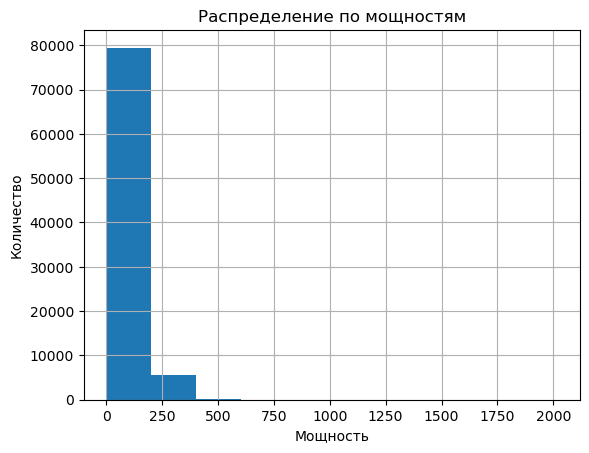

In [38]:
train.power.hist()
plt.title('Распределение по мощностям')
plt.xlabel('Мощность')
plt.ylabel('Количество')
plt.show

In [39]:
train.query('power>500')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
136301,2700.0,NaN,2004.0,auto,612.0,fortwo,125000.0,petrol,smart,NaN
76011,1600.0,bus,2005.0,manual,1202.0,scenic,5000.0,gasoline,renault,NaN
24774,4300.0,NaN,2016.0,manual,696.0,fabia,150000.0,petrol,skoda,no
48744,650.0,small,2003.0,auto,602.0,NaN,90000.0,NaN,lancia,yes
102880,17500.0,sedan,2005.0,NaN,507.0,NaN,150000.0,NaN,bmw,NaN
...,...,...,...,...,...,...,...,...,...,...
96178,600.0,wagon,2000.0,manual,1753.0,focus,150000.0,gasoline,ford,no
87363,3800.0,sedan,2006.0,manual,1223.0,1er,150000.0,gasoline,bmw,yes
136594,1500.0,sedan,1996.0,manual,1596.0,NaN,150000.0,petrol,bmw,NaN
63123,3700.0,small,2005.0,manual,1399.0,rio,70000.0,petrol,kia,no


всего 190 значений. т.к. мощность обычных автомобилей - не выше 250, все, что выше 500 уже являеься спорткарами, однако глядя на данные мы видим, что модели и бренды автомобилей никак не относятся к спорткарам, это обычные автомобили. исправлять на что-то среднее не представляется целесообразным, удаляю

посмотрим теперь авто с очень низкими мощностями.

In [40]:
train = train.query('power<=500')

In [41]:
train.query('power<=10')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1837,1500.0,other,1985.0,auto,0.0,other,50000.0,petrol,chevrolet,NaN
12355,99.0,NaN,2000.0,NaN,0.0,astra,150000.0,NaN,opel,yes
22716,5900.0,sedan,1983.0,manual,0.0,golf,150000.0,petrol,volkswagen,NaN
40971,14800.0,NaN,2010.0,NaN,0.0,c_klasse,150000.0,gasoline,mercedes_benz,NaN
23390,1950.0,sedan,2002.0,manual,0.0,c5,125000.0,petrol,citroen,NaN
...,...,...,...,...,...,...,...,...,...,...
924,140.0,coupe,1997.0,manual,0.0,megane,150000.0,petrol,renault,yes
108387,3700.0,NaN,2011.0,NaN,0.0,3_reihe,60000.0,gasoline,peugeot,yes
66114,1100.0,sedan,1999.0,NaN,0.0,astra,150000.0,NaN,opel,no
129370,590.0,other,1994.0,NaN,0.0,NaN,30000.0,NaN,sonstige_autos,NaN


In [42]:
power_data = train.query('power<=10')

<function matplotlib.pyplot.show(close=None, block=None)>

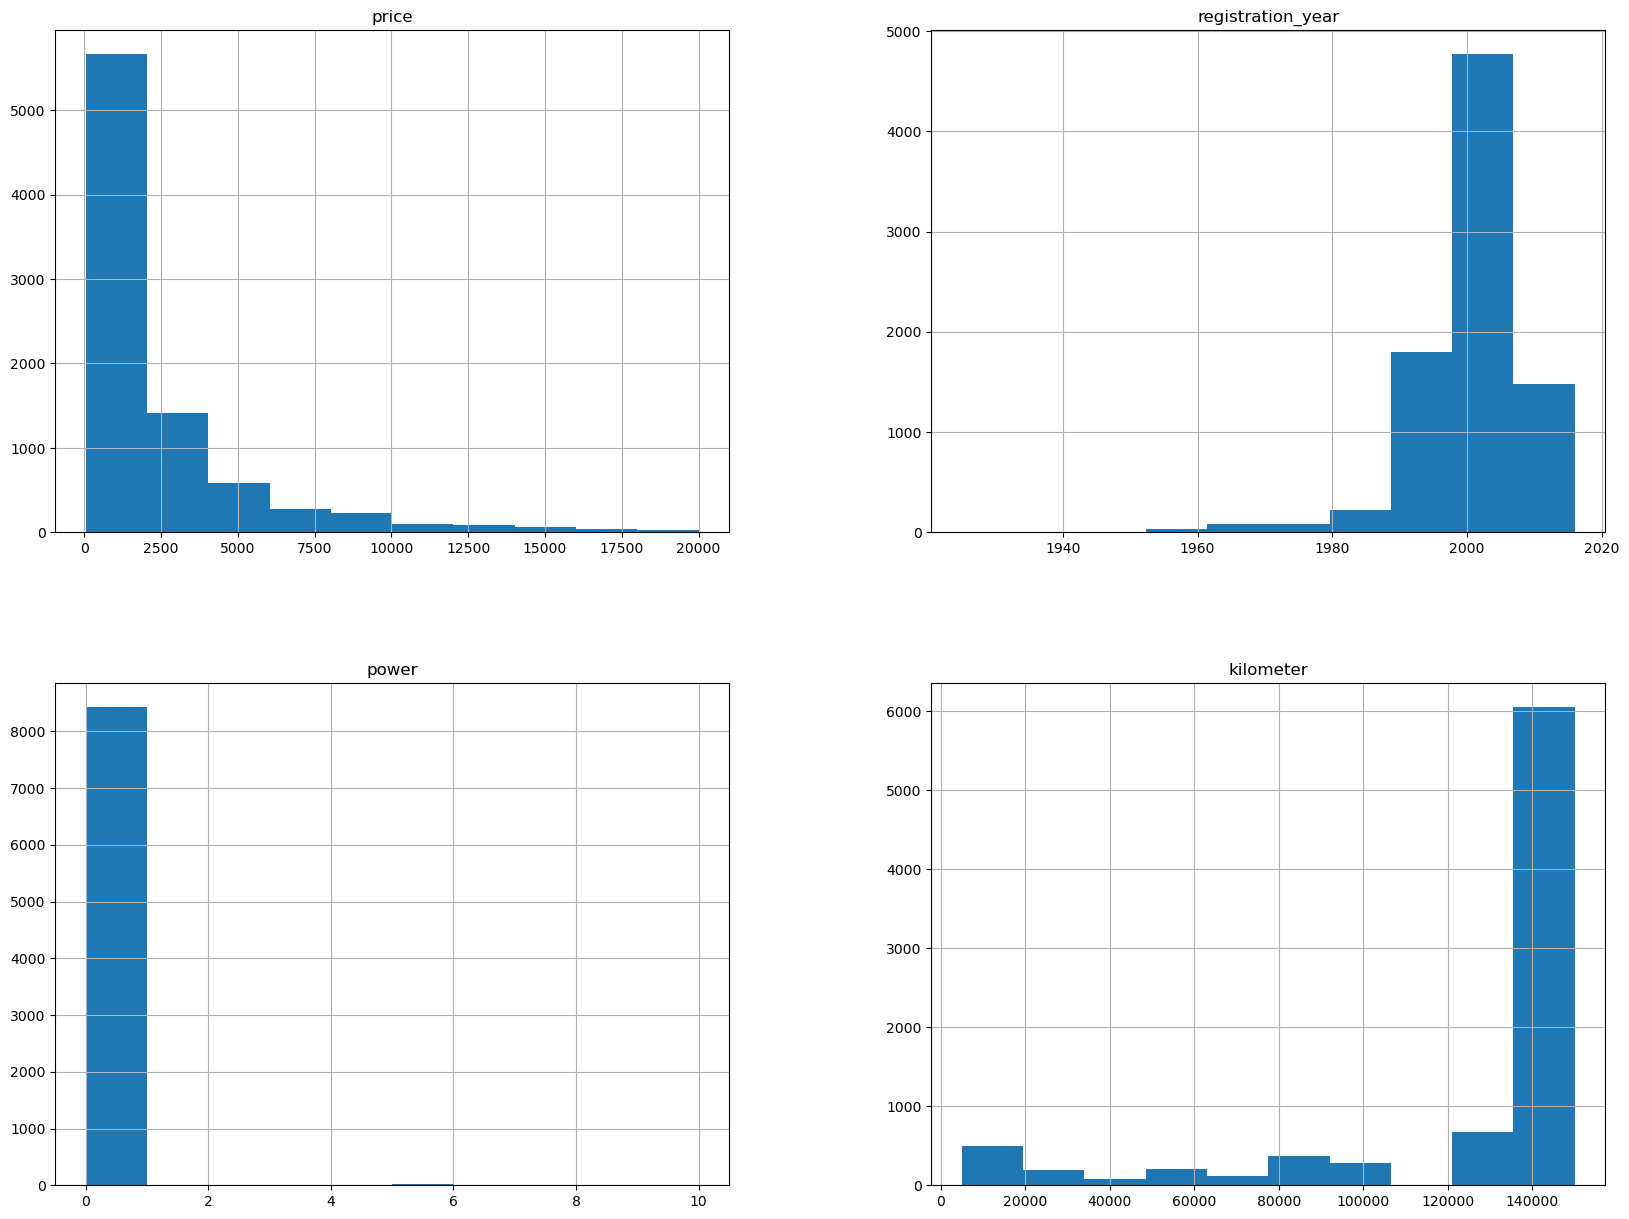

In [43]:
power_data.hist(figsize=(20,15))
plt.show

Похоже, автомобили с нулевыми мощностями- автомобили на разборку, те, которые не на ходу. Тогда они должны стоить дешевле обычных авто. 

Сравним стоимости автомобилей с очень низкими мощностями и нормальными мощностями на нормализованной гистограмме

Text(0, 0.5, 'Частота встречаемости')

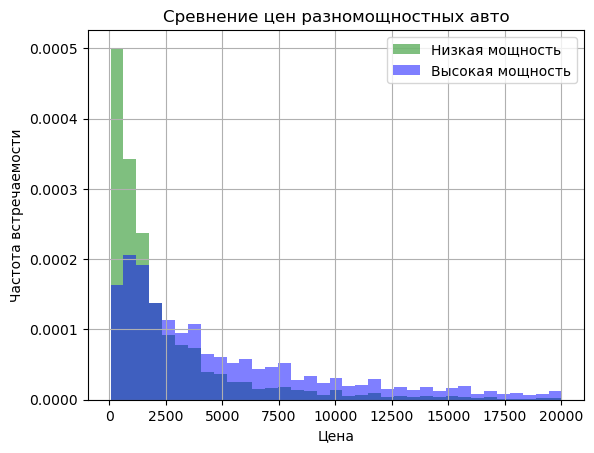

In [44]:
train[train['power']<10]['price'].hist(bins=35, alpha=0.5, color='green', label= 'Низкая мощность', density = True)
train[train['power']>10]['price'].hist(bins=35, alpha=0.5, color='blue',label= 'Высокая мощность', density = True)
plt.show
plt.legend()
plt.title('Сревнение цен разномощностных авто')
plt.xlabel('Цена')
plt.ylabel('Частота встречаемости')


Из графика видим, что автомобили с нулевыми мощностями и низкой ценой почти в 2 раза больше автомобилей с нормальной мощностью. Делаем вывод, что скорее всего предположение, что это авто на разборку верно.

In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85037 entries, 1184 to 31226
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              85037 non-null  float64
 1   vehicle_type       79887 non-null  object 
 2   registration_year  85037 non-null  float64
 3   gearbox            81216 non-null  object 
 4   power              85037 non-null  float64
 5   model              80912 non-null  object 
 6   kilometer          85037 non-null  float64
 7   fuel_type          78567 non-null  object 
 8   brand              85037 non-null  object 
 9   repaired           69404 non-null  object 
dtypes: float64(4), object(6)
memory usage: 7.1+ MB


выведем данные, у которых есть пропуски сразу по 3 признакам- vehicle_type, gearbox, model

In [46]:
train.query('vehicle_type.isnull()&gearbox.isnull()&model.isnull()')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
5150,3599.0,NaN,2006.0,NaN,114.0,NaN,150000.0,gasoline,opel,NaN
8487,300.0,NaN,2016.0,NaN,50.0,NaN,150000.0,petrol,volkswagen,NaN
81317,499.0,NaN,1995.0,NaN,109.0,NaN,150000.0,NaN,volkswagen,yes
45572,2400.0,NaN,2005.0,NaN,0.0,NaN,100000.0,NaN,volkswagen,NaN
24678,10000.0,NaN,1970.0,NaN,0.0,NaN,5000.0,NaN,sonstige_autos,no
...,...,...,...,...,...,...,...,...,...,...
9960,599.0,NaN,2005.0,NaN,0.0,NaN,150000.0,NaN,mazda,NaN
104375,3000.0,NaN,1980.0,NaN,0.0,NaN,150000.0,NaN,volkswagen,NaN
137417,350.0,NaN,1995.0,NaN,0.0,NaN,100000.0,NaN,sonstige_autos,NaN
72610,300.0,NaN,2000.0,NaN,0.0,NaN,5000.0,NaN,mitsubishi,NaN


в этих данных также есть пропуски в fuel_type и repaired. Эти строки также подлежат удалению, т.к. достаточно бессмысленно ждать достоверных предсказаний только по бренду машины, году регистрации и киллометражу. Слишком мало информации.

обработаем пропуски в признаке vehicle_type

In [47]:
train.dropna(axis=0, how='all', subset=['vehicle_type','gearbox','model'], inplace=True)

In [48]:
train[train.vehicle_type.isnull()]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
87765,3200.0,NaN,2016.0,manual,75.0,golf,100000.0,petrol,volkswagen,no
112419,5650.0,NaN,2007.0,manual,143.0,1er,150000.0,gasoline,bmw,NaN
106735,99.0,NaN,2016.0,manual,54.0,punto,150000.0,petrol,fiat,no
17497,6000.0,NaN,2016.0,auto,41.0,NaN,5000.0,NaN,sonstige_autos,no
12355,99.0,NaN,2000.0,NaN,0.0,astra,150000.0,NaN,opel,yes
...,...,...,...,...,...,...,...,...,...,...
87886,600.0,NaN,2002.0,manual,50.0,arosa,150000.0,petrol,seat,no
41796,150.0,NaN,2000.0,manual,0.0,3er,20000.0,petrol,bmw,NaN
119635,4350.0,NaN,2016.0,auto,0.0,c_klasse,150000.0,gasoline,mercedes_benz,yes
108387,3700.0,NaN,2011.0,NaN,0.0,3_reihe,60000.0,gasoline,peugeot,yes


In [49]:
train.vehicle_type.unique()

array(['suv', 'wagon', 'sedan', 'convertible', nan, 'bus', 'small',
       'coupe', 'other'], dtype=object)

Заменим пропуски на заглушки "other" в столбце vehicle_type

In [50]:
train.loc[train['vehicle_type'].isnull(), 'vehicle_type'] = 'other'

In [51]:
train[train.gearbox.isnull()]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
12355,99.0,other,2000.0,NaN,0.0,astra,150000.0,NaN,opel,yes
80577,1200.0,small,1998.0,NaN,75.0,NaN,150000.0,petrol,ford,no
40971,14800.0,other,2010.0,NaN,0.0,c_klasse,150000.0,gasoline,mercedes_benz,NaN
112153,8900.0,suv,2006.0,NaN,0.0,m_klasse,150000.0,gasoline,mercedes_benz,no
85474,900.0,wagon,2000.0,NaN,0.0,other,150000.0,NaN,fiat,NaN
...,...,...,...,...,...,...,...,...,...,...
22239,1400.0,sedan,1990.0,NaN,0.0,other,150000.0,gasoline,mercedes_benz,no
108387,3700.0,other,2011.0,NaN,0.0,3_reihe,60000.0,gasoline,peugeot,yes
59672,500.0,small,2007.0,NaN,69.0,NaN,70000.0,NaN,daihatsu,NaN
66114,1100.0,sedan,1999.0,NaN,0.0,astra,150000.0,NaN,opel,no


заменим пропуски в gearbox на manual

In [52]:
train.loc[train['gearbox'].isnull(), 'gearbox'] = 'manual'

In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84623 entries, 1184 to 31226
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              84623 non-null  float64
 1   vehicle_type       84623 non-null  object 
 2   registration_year  84623 non-null  float64
 3   gearbox            84623 non-null  object 
 4   power              84623 non-null  float64
 5   model              80912 non-null  object 
 6   kilometer          84623 non-null  float64
 7   fuel_type          78467 non-null  object 
 8   brand              84623 non-null  object 
 9   repaired           69357 non-null  object 
dtypes: float64(4), object(6)
memory usage: 7.1+ MB


In [54]:
train[train.model.isnull()]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
99924,499.0,wagon,1996.0,manual,144.0,NaN,150000.0,NaN,volvo,no
98048,4500.0,convertible,1986.0,manual,90.0,NaN,100000.0,petrol,bmw,NaN
17497,6000.0,other,2016.0,auto,41.0,NaN,5000.0,NaN,sonstige_autos,no
83975,250.0,sedan,1995.0,auto,143.0,NaN,150000.0,gasoline,bmw,no
80577,1200.0,small,1998.0,manual,75.0,NaN,150000.0,petrol,ford,no
...,...,...,...,...,...,...,...,...,...,...
108605,7500.0,other,2016.0,manual,109.0,NaN,70000.0,petrol,kia,no
77827,4000.0,small,1998.0,manual,150.0,NaN,150000.0,petrol,audi,no
133341,380.0,small,1998.0,manual,58.0,NaN,150000.0,NaN,renault,NaN
59672,500.0,small,2007.0,manual,69.0,NaN,70000.0,NaN,daihatsu,NaN


In [55]:
train[train.model == 'other']

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
72376,1449.0,wagon,1998.0,manual,75.0,other,125000.0,NaN,fiat,NaN
126453,11950.0,bus,2012.0,manual,125.0,other,50000.0,petrol,kia,no
65865,1400.0,sedan,1996.0,manual,101.0,other,125000.0,petrol,volkswagen,no
17480,2000.0,bus,2005.0,manual,139.0,other,100000.0,petrol,kia,yes
37341,6500.0,small,2009.0,auto,68.0,other,80000.0,petrol,toyota,no
...,...,...,...,...,...,...,...,...,...,...
101965,8999.0,coupe,1981.0,auto,179.0,other,40000.0,petrol,chevrolet,no
14523,1590.0,sedan,1996.0,manual,136.0,other,150000.0,petrol,mercedes_benz,no
6037,2100.0,bus,2003.0,manual,107.0,other,150000.0,gasoline,citroen,no
60737,6200.0,convertible,2006.0,manual,100.0,other,80000.0,petrol,peugeot,no


Думаю, целесообразно поставить заглушку 'other' в колонке model, 'petrol' в колонке 'fuel_type'

In [56]:
train.loc[train['model'].isnull(), 'model'] = 'other'

In [57]:
train.loc[train['fuel_type'].isnull(), 'fuel_type'] = 'petrol'

In [58]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84623 entries, 1184 to 31226
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              84623 non-null  float64
 1   vehicle_type       84623 non-null  object 
 2   registration_year  84623 non-null  float64
 3   gearbox            84623 non-null  object 
 4   power              84623 non-null  float64
 5   model              84623 non-null  object 
 6   kilometer          84623 non-null  float64
 7   fuel_type          84623 non-null  object 
 8   brand              84623 non-null  object 
 9   repaired           69357 non-null  object 
dtypes: float64(4), object(6)
memory usage: 7.1+ MB


Теперь обработаем пропуски в признаке repaired. ПОсмотрим,какие уникальные значения есть в этой колонке

In [59]:
train.repaired.unique()

array(['no', nan, 'yes'], dtype=object)

Думаю, здесь лучше поставить заглушку "unknown". Т.к. факт того, была ли машина в ремонте или нет влияет на ее итоговую стоимость.

In [60]:
train.loc[train['repaired'].isnull(),'repaired'] = 'unknown'

проверим, что нет больше пропусков и далее проверим данные на дубликаты

In [61]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84623 entries, 1184 to 31226
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              84623 non-null  float64
 1   vehicle_type       84623 non-null  object 
 2   registration_year  84623 non-null  float64
 3   gearbox            84623 non-null  object 
 4   power              84623 non-null  float64
 5   model              84623 non-null  object 
 6   kilometer          84623 non-null  float64
 7   fuel_type          84623 non-null  object 
 8   brand              84623 non-null  object 
 9   repaired           84623 non-null  object 
dtypes: float64(4), object(6)
memory usage: 7.1+ MB


In [62]:
train_features = train.drop('price',axis=1)
train_target = train['price']

Теперь переведем категориальные данные в численные. Посмотрим, сколько значений в каждом категориальном признаке

In [63]:
len(data.vehicle_type.unique())

9

In [64]:
len(data.gearbox.unique())

3

In [65]:
len(data.model.unique())

250

In [66]:
len(data.fuel_type.unique())

8

In [67]:
len(data.brand.unique())

41

In [68]:
len(data.repaired.unique())

3

Делать огромное количество признаков не хочется, поэтому для признаков vehicle_type,gearbox,fuel_type и repaired применим метод OHE,а для model и brand - ordinary

In [69]:
ohe_names = ['vehicle_type','gearbox','fuel_type','repaired']

In [70]:
encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
encoder.fit(train_features[ohe_names])
ohe_train = encoder.transform(train_features[ohe_names])
ohe_data_train = pd.DataFrame(ohe_train, columns=encoder.get_feature_names(ohe_names), index=train_features.index)

ohe_valid = encoder.transform(valid_features[ohe_names])
ohe_data_valid = pd.DataFrame(ohe_valid, columns=encoder.get_feature_names(ohe_names), index=valid_features.index)

ohe_test = encoder.transform(test_features[ohe_names])
ohe_data_test = pd.DataFrame(ohe_test, columns=encoder.get_feature_names(ohe_names), index=test_features.index)


In [71]:
num_train = train_features.drop(ohe_names, axis=1)
num_valid = valid_features.drop(ohe_names, axis=1)
num_test = test_features.drop(ohe_names, axis=1)

In [72]:
features_train = pd.concat([num_train,ohe_data_train], axis=1)
features_valid = pd.concat([num_valid, ohe_data_valid], axis=1)
features_test = pd.concat([num_test, ohe_data_test], axis=1)

Теперь признаки model и brand

In [73]:
encoder = OrdinalEncoder(handle_unknown= 'use_encoded_value',unknown_value=300)
encoder.fit(features_train[['model']])
features_train['model'] = encoder.transform(features_train[['model']])
features_valid['model'] = encoder.transform(features_valid[['model']])
features_test['model'] = encoder.transform(features_test[['model']])

In [74]:
encoder = OrdinalEncoder(handle_unknown= 'use_encoded_value',unknown_value=300)
encoder.fit(features_train[['brand']])
features_train['brand'] = encoder.transform(features_train[['brand']])
features_valid['brand'] = encoder.transform(features_valid[['brand']])
features_test['brand'] = encoder.transform(features_test[['brand']])

Теперь промасштабируем признаки

In [75]:
numeric = ['registration_year', 'power', 'kilometer']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

## Обучение моделей

Напишем функцию вычисления RMSE

In [76]:
def RMSE(target,predictions):
    MSE = mean_squared_error(target, predictions)
    return MSE ** 0.5
RMSE_score = make_scorer(RMSE, greater_is_better=False)

In [77]:
model_list=[]

In [78]:
def best_model(model, params, features_train, target_train, features_valid, target_valid):
    start_time = time.time()
    model_name = GridSearchCV(model, param_grid = params, cv=5,
                                            scoring = RMSE_score, n_jobs=-1)
    model_name.fit(features_train,target_train)
    first_time = time.time() - start_time
    start_time = time.time()
    predict = model_name.predict(features_valid)
    second_time = time.time() - start_time
    model_list.append(model_name)
    n = len(model_list)
    return first_time, second_time, RMSE(target_valid, predict),n

Модель линейной регресии с регуляризацией

In [79]:
ridge = Ridge()
ridge_param = {'alpha': np.logspace(-4, 4, 20)}

In [80]:
ridge_model = best_model(ridge, ridge_param, features_train, train_target, features_valid, valid_target)

In [81]:
ridge_model

(9.785699367523193, 0.009490489959716797, 13347.10415116156, 1)

Время обучения- 20 секунд, время предсказания- 0.0083, метрика- 11806.73599709747. 

Модель LGBM

In [82]:
lgbm_params = {
    'n_estimators': [10,50,100],
    'max_depth': [15,30],
    'num_leaves': [10,20,31],
    'learning_rate': [0.1]
}
lgbm_reg_model = LGBMRegressor(random_state=2023)

In [83]:
lgbm_model = best_model(lgbm_reg_model, lgbm_params, features_train, train_target, features_valid, valid_target )

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 84623, number of used features: 21
[LightGBM] [Info] Start training from score 4688.108434
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [84]:
lgbm_model

(29.192648887634277, 0.08922171592712402, 2081.5628646243717, 2)

In [85]:
cat_param = { 'learning_rate': [0.1],
    'iterations': [10,50,100],
    'max_depth': [10,20]}
cat_model = CatBoostRegressor(random_state=2023)

In [86]:
cat_model = best_model(cat_model, cat_param, features_train, train_target, features_valid, valid_target )

0:	learn: 4279.4194248	total: 198ms	remaining: 19.6s
1:	learn: 3999.2709375	total: 223ms	remaining: 10.9s
2:	learn: 3748.4292250	total: 244ms	remaining: 7.88s
3:	learn: 3527.2914624	total: 262ms	remaining: 6.3s
4:	learn: 3334.5578544	total: 285ms	remaining: 5.42s
5:	learn: 3163.9277756	total: 308ms	remaining: 4.82s
6:	learn: 3009.3726636	total: 330ms	remaining: 4.39s
7:	learn: 2874.8207716	total: 353ms	remaining: 4.07s
8:	learn: 2757.1407077	total: 376ms	remaining: 3.8s
9:	learn: 2658.9654704	total: 398ms	remaining: 3.58s
10:	learn: 2565.9905768	total: 424ms	remaining: 3.43s
11:	learn: 2487.9024181	total: 449ms	remaining: 3.3s
12:	learn: 2415.5652594	total: 472ms	remaining: 3.16s
13:	learn: 2353.8888444	total: 496ms	remaining: 3.04s
14:	learn: 2298.6791798	total: 520ms	remaining: 2.95s
15:	learn: 2246.2733307	total: 543ms	remaining: 2.85s
16:	learn: 2204.8785033	total: 567ms	remaining: 2.77s
17:	learn: 2167.0835475	total: 592ms	remaining: 2.7s
18:	learn: 2135.1746493	total: 617ms	remai

In [87]:
cat_model

(19.6666841506958, 0.021389245986938477, 2164.2586335255546, 3)

In [88]:
constant_model = DummyRegressor(strategy='mean')


In [89]:
constant_model.fit(features_train,train_target)
constant_pred = constant_model.predict(features_valid)
RMSE(valid_target,constant_pred)

4521.626759865161

## Анализ моделей

In [90]:
model_table = pd.DataFrame([ridge_model, lgbm_model, cat_model], columns=['Время обучения', 'Время предсказания', 'RMSE','номер модели'], index=['Ridge','LGBM','CatBoost'])

In [91]:
model_table

,Время обучения,Время предсказания,RMSE,номер модели
Ridge,9.785699,0.009490,13347.104151,1
LGBM,29.192649,0.089222,2081.562865,2
CatBoost,19.666684,0.021389,2164.258634,3


## Тестирование лучшей модели

Были проверены 3 модели: линейная регрессия, Модель LGBM, catboost. По результатам метрики RMSE лучше всего сея показали модели LGBM и catboost. В обоих случаях метрика ниже 2500. Но Так как в условиях было подобрать модель с наименьшим временем обучения и предсказания, делаем выбор в пользу catboost. Проверка случайно моделью показала, что предсказания адекватны. ПРоверим итоговую модель на тестовой выборке

In [92]:
end_predict = model_list[2].predict(features_test)

In [93]:
RMSE (test_target, end_predict)

2190.215521783534

Модель выбора- catboost